In [3]:
!pip install tensorflow

In [4]:
!pip install keras-tuner

In [5]:
!pip install xgboost

In [2]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/9.5 MB 5.6 MB/s eta 0:00:02
   ---------- ----------------------------- 2.6/9.5 MB 5.8 MB/s eta 0:00:02
   ---------------- ----------------------- 3.9/9.5 MB 5.9 MB/s eta 0:00:01
   --------------------- ------------------ 5.2/9.5 MB 5.9 MB/s eta 0:00:01
   --------------------------- ------------ 6.6/9.5 MB 6.0 MB/s eta 0:00:01
   -------------------------------- ------- 7.9/9.5 MB 6.2 MB/s eta 0:00:01
   ---------------------------------------  9.4/9.5 MB 6.2 MB/s eta 0:00:01
   ---------------------------------------- 9.5/9.5 MB 5.9 MB/s  0:00:01

   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- --

Train+Val length: 9132 | Test length: 2284


C:\Users\Alketa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Alketa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Alketa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                      Ngarkesa Totale   No. Observations:                 9132
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 24)   Log Likelihood              -48290.206
Date:                              Mon, 15 Dec 2025   AIC                          96594.412
Time:                                      00:12:09   BIC                          96644.227
Sample:                                           0   HQIC                         96611.353
                                             - 9132                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6359      0.018     93.244      0.000       1.602       1.670
ar.L2         -0.72

C:\Users\Alketa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Alketa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Alketa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


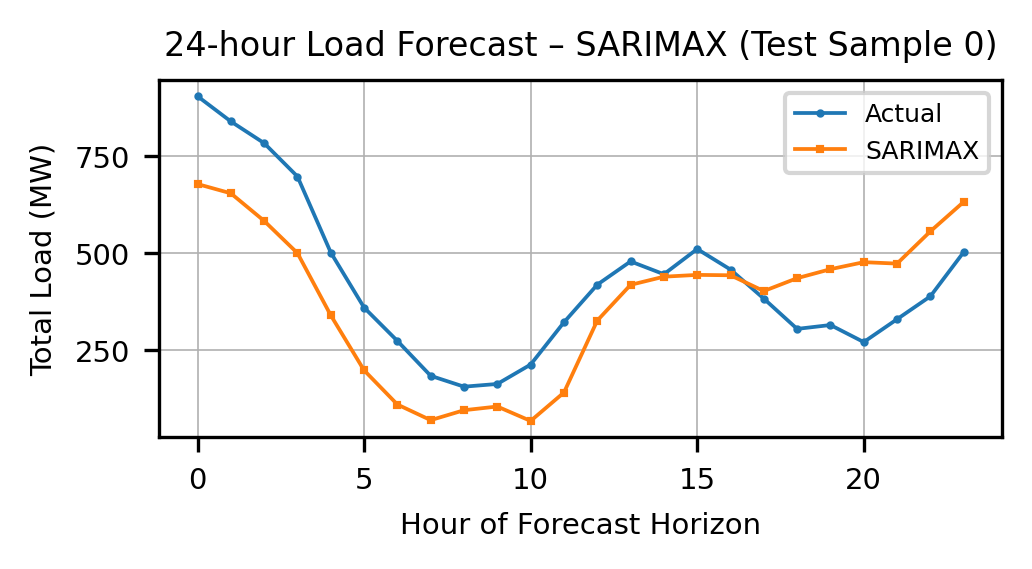

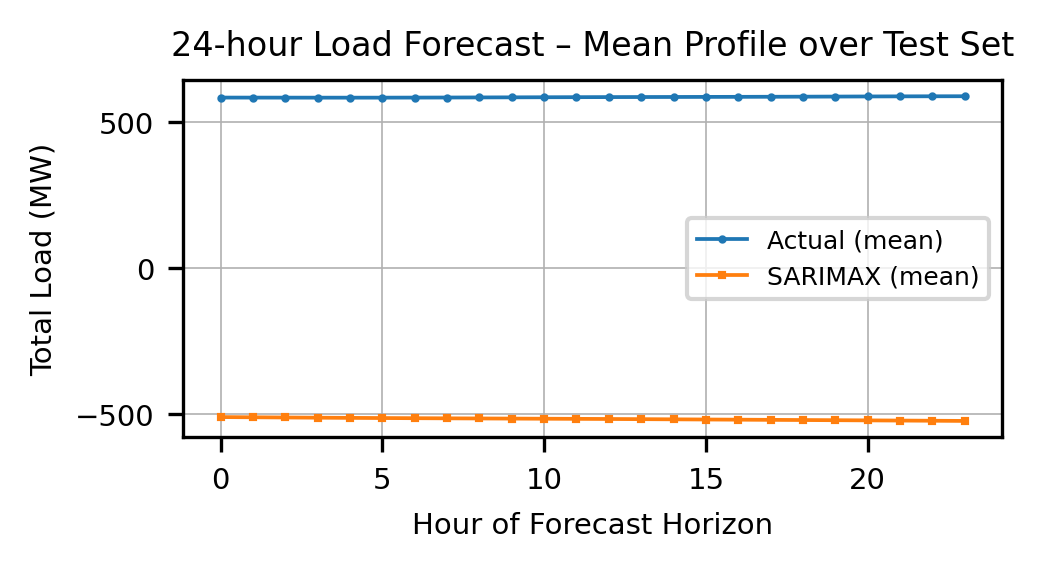

In [1]:
# ======================= SARIMAX ONLY =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

np.random.seed(42)

# =================== 1) Load & clean =================
df = pd.read_csv("ost_data_clean.csv", sep=';', engine='python')

df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
df['Ora'] = (
    df['Ora']
    .astype(str)
    .str.extract(r'(\d+)', expand=False)
    .astype(int)
    .astype(str)
    .str.zfill(2)
)

df['Datetime'] = pd.to_datetime(
    df['Data'].dt.strftime('%Y-%m-%d') + ' ' + df['Ora'],
    format='%Y-%m-%d %H',
    errors='coerce'
)
df.set_index('Datetime', inplace=True)
df.dropna(inplace=True)

# (Optional) keep only target column for SARIMAX
target_col = 'Ngarkesa Totale'
df = df[[target_col]].copy()
df.dropna(inplace=True)

# =================== 2) Train/Val/Test split (70/10/20) =================
n_total     = len(df)
i_train_end = int(n_total * 0.70)
i_val_end   = int(n_total * 0.80)

y_full     = df[target_col]
y_trainval = y_full.iloc[:i_val_end]   # train + val
y_test_ser = y_full.iloc[i_val_end:]   # test

print("Train+Val length:", len(y_trainval), "| Test length:", len(y_test_ser))

# =================== 3) Fit SARIMAX =========================
# Daily seasonality (24 hours)
arima_order    = (2, 1, 2)
seasonal_order = (1, 0, 1, 24)

sarimax_model = SARIMAX(
    y_trainval,
    order=arima_order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_res = sarimax_model.fit(disp=False)
print(sarimax_res.summary())

# =================== 4) Forecast on TEST ====================
fc = sarimax_res.get_forecast(steps=len(y_test_ser))
y_arima_test = fc.predicted_mean
y_arima_test.index = y_test_ser.index  # align index

# =================== 5) Convert to 24-hour windows ======================
n_input  = 24
n_output = 24

def make_windows_from_series(series, n_in=24, n_out=24):
    values = series.values
    windows = []
    for i in range(n_in, len(series) - n_out + 1):
        windows.append(values[i:i+n_out])
    return np.array(windows)

y_te_true  = make_windows_from_series(y_test_ser,  n_input, n_output)
y_te_arima = make_windows_from_series(y_arima_test, n_input, n_output)

print("y_te_true shape:", y_te_true.shape, "| y_te_arima shape:", y_te_arima.shape)

# =================== 6) Metrics =============================
def eval_metrics(y_true_2d, y_pred_2d, tag):
    yt = y_true_2d.reshape(-1)
    yp = y_pred_2d.reshape(-1)

    mae  = mean_absolute_error(yt, yp)
    rmse = mean_squared_error(yt, yp, squared=False)

    eps = 1e-6
    yt_safe = np.where(yt == 0, eps, yt)
    mape = mean_absolute_percentage_error(yt_safe, yp) * 100

    r2  = r2_score(yt, yp)
    acc = 100 - mape

    print(f"[{tag}] MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}% | R²: {r2:.4f} | Accuracy: {acc:.2f}%")
    return mae, rmse, mape, r2, acc

eval_metrics(y_te_true, y_te_arima, "SARIMAX baseline")

# =================== 7) 24-hour plot (one sample) ======================
sample_idx = 0
hours = np.arange(24)

plt.figure(figsize=(3.54, 2), dpi=300)
plt.plot(hours, y_te_true[sample_idx],  marker='o', markersize=1, linewidth=0.9, label='Actual')
plt.plot(hours, y_te_arima[sample_idx], marker='s', markersize=1, linewidth=0.9, label='SARIMAX')

plt.title(f'24-hour Load Forecast – SARIMAX (Test Sample {sample_idx})', fontsize=8)
plt.xlabel('Hour of Forecast Horizon', fontsize=7)
plt.ylabel('Total Load (MW)', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(True, linewidth=0.4)
plt.legend(fontsize=6)
plt.tight_layout()
plt.savefig(f"forecast_SARIMAX_sample{sample_idx}.png", dpi=300, bbox_inches='tight')
plt.show()

# =================== 8) Optional: mean profile over test set =============
mean_true  = y_te_true.mean(axis=0)
mean_arima = y_te_arima.mean(axis=0)

plt.figure(figsize=(3.54, 2), dpi=300)
plt.plot(hours, mean_true,  marker='o', markersize=1, linewidth=0.9, label='Actual (mean)')
plt.plot(hours, mean_arima, marker='s', markersize=1, linewidth=0.9, label='SARIMAX (mean)')

plt.title('24-hour Load Forecast – Mean Profile over Test Set', fontsize=8)
plt.xlabel('Hour of Forecast Horizon', fontsize=7)
plt.ylabel('Total Load (MW)', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(True, linewidth=0.4)
plt.legend(fontsize=6)
plt.tight_layout()
plt.savefig("forecast_SARIMAX_meanprofile.png", dpi=300, bbox_inches='tight')
plt.show()

